In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler


num_cycles = 10000
num_samples = num_cycles
np.random.seed(42)

driving_patterns = np.random.choice([0, 1, 2], size=num_samples, p=[0.3, 0.45, 0.25])
charging_patterns = np.random.choice([0, 1, 2], size=num_samples, p=[0.3, 0.45, 0.25])
temperatures = np.random.normal(loc=25, scale=5, size=num_samples)

DoD = np.random.uniform(50, 100, size=num_samples) ### Depth of discharge (how much battery has been used)

trip_length = np.random.normal(loc=50, scale=20, size=num_samples)
cycles = np.arange(num_samples)

SoH = np.zeros(num_samples)
FCR = np.zeros(num_samples)

SoH[0] = 100.0
base_range = 500

k_base = [0.8, 1.0, 1.2]
charging_effect = [0.9, 1.0, 1.2]
temp_effect = lambda T: 1 + 0.005*(T-25)
dod_effect = lambda d: 1 + 0.002*(d-80)
trip_effect = lambda t: 1 + 0.001*(t-50)
base_degradation_rate = 0.005


for i in range(1, num_samples):
    dp = driving_patterns[i]
    cp = charging_patterns[i]
    temp = temperatures[i]
    dod = DoD[i]
    trip = trip_length[i]
    degradation_step = (base_degradation_rate * k_base[dp] * charging_effect[cp] * dod_effect(dod) * trip_effect(trip) * temp_effect(temp))
    SoH[i] = SoH[i-1] - degradation_step
    SoH[i] = max(50, SoH[i])
    FCR[i] = base_range * (SoH[i]/100) * (1 - 0.02*dp) * temp_effect(temp) * (1 - 0.01*cp)


FCR[0] = base_range * (SoH[0]/100) * (1 - 0.02*driving_patterns[0]) * temp_effect(temperatures[0]) * (1 - 0.01*charging_patterns[0])


df = pd.DataFrame({
    'cycle': cycles,
    'temperature': temperatures,
    'driving_pattern': driving_patterns,
    'charging_pattern': charging_patterns,
    'DoD': DoD,
    'trip_length_km': trip_length,
    'SoH': SoH,
    'FCR': FCR
})

df.to_csv('ev_battery_data_final.csv', index=False)

print("Data Generation Complete")
print(df.head(10))

Data Generation Complete
   cycle  temperature  driving_pattern  charging_pattern        DoD  \
0      0    20.980984                1                 1  66.179191   
1      1    27.929959                2                 1  57.440415   
2      2    31.531402                1                 0  83.227683   
3      3    18.865422                1                 1  62.259321   
4      4    33.561539                0                 1  72.815795   
5      5    24.357245                0                 2  74.581137   
6      6    20.124893                0                 0  73.859978   
7      7    28.788774                2                 1  79.922457   
8      8    22.767728                1                 2  51.472685   
9      9    24.591317                1                 2  99.484125   

   trip_length_km         SoH         FCR  
0       64.219388  100.000000  475.351877  
1       51.888120   99.994176  482.133500  
2       83.214940   99.989344  505.948014  
3       75.172369

In [2]:
df = pd.read_csv('ev_battery_data_final.csv')

base_range = 500
R0 = 0.05
alpha = 0.5

def temp_factor(T):
    return 1 + 0.005*(T-25)

def dod_factor(DoD):
    return 1 + 0.002*(DoD-80)

def trip_factor(trip):
    return 1 + 0.001*(trip-50)

k_base = [0.8, 1.0, 1.2]
charging_effect = [0.9, 1.0, 1.2]

SoH_phys = []
FCR_phys = []
R_int = []

for i, row in df.iterrows():
    dp = int(row['driving_pattern'])
    cp = int(row['charging_pattern'])
    temp = row['temperature']
    dod = row['DoD']
    trip = row['trip_length_km']
    cycle = row['cycle']
    
    soh = 100 - k_base[dp] * charging_effect[cp] * dod_factor(dod) * trip_factor(trip) * np.sqrt(cycle) * temp_factor(temp)
    soh = max(50, soh)
    SoH_phys.append(soh)
    
    r_int = R0 * (1 + alpha*(100-soh)/100)
    R_int.append(r_int)
    
    fcr = base_range * (soh/100) * (1 - 0.02*dp) * temp_factor(temp) * (1 - 0.01*cp)
    FCR_phys.append(fcr)


df['SoH_phys'] = SoH_phys
df['FCR_phys'] = FCR_phys
df['R_int'] = R_int


print("\n--- Data Prep Complete ---")
print(df.head())


--- Data Prep Complete ---
   cycle  temperature  driving_pattern  charging_pattern        DoD  \
0      0    20.980984                1                 1  66.179191   
1      1    27.929959                2                 1  57.440415   
2      2    31.531402                1                 0  83.227683   
3      3    18.865422                1                 1  62.259321   
4      4    33.561539                0                 1  72.815795   

   trip_length_km         SoH         FCR    SoH_phys    FCR_phys     R_int  
0       64.219388  100.000000  475.351877  100.000000  475.351877  0.050000  
1       51.888120   99.994176  482.133500   98.835161  476.545177  0.050291  
2       83.214940   99.989344  505.948014   98.633219  499.086000  0.050342  
3       75.172369   99.984551  470.147937   98.339884  462.414372  0.050415  
4       80.957121   99.980313  516.088184   98.304572  507.438180  0.050424  


In [3]:
feature_cols = ['cycle','temperature','driving_pattern','charging_pattern',
'DoD','trip_length_km']

target_cols = ['SoH','FCR']

physics_constraint_cols = ['SoH_phys', 'FCR_phys']


seq_len = 10
y_true_original = df[target_cols].values[seq_len:]
cycles_unscaled_for_reporting = df['cycle'].values[seq_len:]


feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()


df[feature_cols] = feature_scaler.fit_transform(df[feature_cols])

df[target_cols] = target_scaler.fit_transform(df[target_cols].values)

df[physics_constraint_cols] = target_scaler.transform(df[physics_constraint_cols].values)


class EVBatteryDataset(Dataset):

    def __init__(self, df, seq_len=10):
        self.seq_len = seq_len
        self.features = df[feature_cols].values.astype(np.float32)
        self.targets = df[target_cols].values.astype(np.float32)
        self.physics = df[physics_constraint_cols].values.astype(np.float32)
  
    def __len__(self):
        return len(self.features) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.features[idx:idx+self.seq_len]
        y = self.targets[idx+self.seq_len]
        phys = self.physics[idx+self.seq_len] 
        return torch.tensor(x), torch.tensor(y), torch.tensor(phys)

dataset = EVBatteryDataset(df, seq_len=seq_len)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


class HybridLSTM(nn.Module):

    def __init__(self, input_size=6, hidden_size=128, num_layers=1, output_size=2):
        super(HybridLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


model = HybridLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)


def physics_loss(y_pred, y_true, phys):
    
    mse = nn.MSELoss()(y_pred, y_true)
    delta_soh = y_pred[:,0] - y_true[:,0]
    soh_penalty = torch.mean(torch.clamp(delta_soh, min=0))
    fcr_penalty = torch.mean(torch.clamp(y_pred[:,1] - phys[:,1], min=0))
    return mse + 0.1*soh_penalty + 0.1*fcr_penalty


print(f"Model input features: {len(feature_cols)} {feature_cols}")

Model input features: 6 ['cycle', 'temperature', 'driving_pattern', 'charging_pattern', 'DoD', 'trip_length_km']


In [4]:
device = 'cuda'
model.to(device)
print(f"Training on device: {device}")


num_epochs = 180

for epoch in range(num_epochs):

    model.train()
    total_loss = 0
    for x, y, phys in dataloader:
        x = x.float().to(device)
        y = y.float().to(device)
        phys = phys.float().to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = physics_loss(y_pred, y, phys)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    if (epoch+1) % 15 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")


print("Model Training Complete")

Training on device: cuda
Epoch 15/180, Loss: 0.0276
Epoch 30/180, Loss: 0.0275
Epoch 45/180, Loss: 0.0275
Epoch 60/180, Loss: 0.0275
Epoch 75/180, Loss: 0.0275
Epoch 90/180, Loss: 0.0274
Epoch 105/180, Loss: 0.0275
Epoch 120/180, Loss: 0.0274
Epoch 135/180, Loss: 0.0274
Epoch 150/180, Loss: 0.0274
Epoch 165/180, Loss: 0.0274
Epoch 180/180, Loss: 0.0274
Model Training Complete


In [5]:
model.eval()
pred_results = []

features_tensor = torch.tensor(df[feature_cols].values, dtype=torch.float32).to(device)


with torch.no_grad():

    for i in range(seq_len, len(df)):
        x_seq = features_tensor[i-seq_len:i].unsqueeze(0)
        y_pred = model(x_seq)
        pred_results.append(y_pred[0].cpu().numpy())

pred_results = np.array(pred_results)
pred_unscaled = target_scaler.inverse_transform(pred_results)


cycles = cycles_unscaled_for_reporting
pred_df = pd.DataFrame({
    'cycle': cycles,
    'SoH_pred': pred_unscaled[:,0],
    'FCR_pred': pred_unscaled[:,1]
})

target_soh = [100, 90, 80, 70, 60]
table = []
for soh in target_soh:
    row = pred_df.iloc[(pred_df['SoH_pred'] - soh).abs().argsort()[:1]]
    table.append({
        'Target SoH (%)': soh,
        'Predicted SoH (%)': round(float(row['SoH_pred']),2),
        'Predicted Full-Charge Range (km)': round(float(row['FCR_pred']),2),
        'Cycle': int(row['cycle'])
    })

results_df = pd.DataFrame(table)
print("\nPredicted Range Table")
print(results_df)


Predicted Range Table
   Target SoH (%)  Predicted SoH (%)  Predicted Full-Charge Range (km)  Cycle
0             100             100.05                            477.84     65
1              90              90.00                            405.11   1988
2              80              80.00                            359.72   3978
3              70              70.00                            310.61   5981
4              60              60.00                            261.23   8014


C:\Users\Jai\AppData\Local\Temp\ipykernel_22928\2129386855.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted SoH (%)': round(float(row['SoH_pred']),2),
C:\Users\Jai\AppData\Local\Temp\ipykernel_22928\2129386855.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted Full-Charge Range (km)': round(float(row['FCR_pred']),2),
C:\Users\Jai\AppData\Local\Temp\ipykernel_22928\2129386855.py:33: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  'Cycle': int(row['cycle'])
C:\Users\Jai\AppData\Local\Temp\ipykernel_22928\2129386855.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  'Predicted

In [6]:
### HYBRID PHYSICS - LSTM PREDICTIONS


from sklearn.metrics import mean_absolute_error

mae_soh_hybrid = mean_absolute_error(y_true_original[:, 0], pred_unscaled[:, 0])
mae_fcr_hybrid = mean_absolute_error(y_true_original[:, 1], pred_unscaled[:, 1])

metrics_df = pd.DataFrame({
    'Metric': ['MAE'],
    'SoH': [mae_soh_hybrid],
    'FCR': [mae_fcr_hybrid]
})

print("\nHybrid - Metrics")
print(metrics_df)


Hybrid - Metrics
  Metric       SoH        FCR
0    MAE  0.124188  28.792263


In [7]:
import shap

X_sample = df[feature_cols].iloc[seq_len:110].values.astype(np.float32)


def model_predict_last_step(input_np):

    seq_input = np.repeat(input_np[:, np.newaxis, :], seq_len, axis=1)
    input_tensor = torch.tensor(seq_input, dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(input_tensor)
    return out[:, 0].cpu().numpy()

explainer = shap.KernelExplainer(model_predict_last_step, X_sample)
shap_values = explainer.shap_values(X_sample)


feature_importance = np.mean(np.abs(shap_values), axis=0)
shap_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance (mean abs SHAP)': feature_importance
}).sort_values(by='Importance (mean abs SHAP)', ascending=False)


print("\nSHAP Feature Importance")
print(shap_df)

  0%|          | 0/100 [00:00<?, ?it/s]


SHAP Feature Importance
            Feature  Importance (mean abs SHAP)
4               DoD                    0.010727
2   driving_pattern                    0.010654
3  charging_pattern                    0.006634
5    trip_length_km                    0.006422
1       temperature                    0.005003
0             cycle                    0.002176


In [8]:
pred_df['SoH_diff'] = pred_df['SoH_pred'].diff().fillna(0)
pred_df['Degradation_perc_per_cycle'] = -pred_df['SoH_diff']

avg_degradation = pred_df['Degradation_perc_per_cycle'].mean()

degradation_df = pd.DataFrame({
    'Metric': ['Average Degradation per cycle (%)'],
    'Value': [avg_degradation]
})

print("\n--- Degradation Analysis ---")
print(degradation_df)

top_degradation_df = pred_df[['cycle','SoH_pred','Degradation_perc_per_cycle']].sort_values(
    by='Degradation_perc_per_cycle', ascending=False
).head(10)

print("\nTop 10 cycles with highest degradation:")
print(top_degradation_df)


--- Degradation Analysis ---
                              Metric     Value
0  Average Degradation per cycle (%)  0.004944

Top 10 cycles with highest degradation:
      cycle   SoH_pred  Degradation_perc_per_cycle
116     126  98.930458                    0.896477
113     123  98.631630                    0.659622
13       23  99.554016                    0.584862
56       66  99.487167                    0.561409
168     178  98.686134                    0.554504
659     669  96.252174                    0.507057
247     257  98.282288                    0.502708
238     248  98.240166                    0.496040
193     203  98.749603                    0.471832
9988   9998  50.071136                    0.466408


In [9]:
### PHYSICS ONLY PREDICTIONS

from sklearn.metrics import mean_absolute_error


soh_phys = df['SoH_phys'].values[seq_len:]
fcr_phys = df['FCR_phys'].values[seq_len:]


soh_true = y_true_original[:, 0]
fcr_true = y_true_original[:, 1]


mae_soh_phys = mean_absolute_error(soh_true, soh_phys)
mae_fcr_phys = mean_absolute_error(fcr_true, fcr_phys)

print(f"Physics-only Model - MAE SoH: {mae_soh_phys:.3f}, MAE FCR: {mae_fcr_phys:.3f}")


Physics-only Model - MAE SoH: 74.906, MAE FCR: 364.348


In [10]:
### ML ONLY PREDICTIONS


class PureLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=2, output_size=2):
        super(PureLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


pure_model = PureLSTM().to(device)
optimizer = torch.optim.Adam(pure_model.parameters(), lr=0.002)
criterion = nn.MSELoss()

for epoch in range(100):
    pure_model.train()
    total_loss = 0
    for x, y, phys in dataloader:
        x, y = x.to(device).float(), y.to(device).float()
        optimizer.zero_grad()
        y_pred = pure_model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/100, Pure LSTM Loss: {total_loss/len(dataloader):.4f}")

pure_model.eval()
pred_results_pure = []

with torch.no_grad():
    for i in range(seq_len, len(df)):
        x_seq = features_tensor[i-seq_len:i].unsqueeze(0)
        y_pred = pure_model(x_seq)
        pred_results_pure.append(y_pred[0].cpu().numpy())

pred_results_pure = np.array(pred_results_pure)
pred_unscaled_pure = target_scaler.inverse_transform(pred_results_pure)

mae_soh_pure = mean_absolute_error(soh_true, pred_unscaled_pure[:, 0])
mae_fcr_pure = mean_absolute_error(fcr_true, pred_unscaled_pure[:, 1])

print(f"Pure LSTM - MAE SoH: {mae_soh_pure:.3f}, MAE FCR: {mae_fcr_pure:.3f}")        

Epoch 20/100, Pure LSTM Loss: 0.0007
Epoch 40/100, Pure LSTM Loss: 0.0007
Epoch 60/100, Pure LSTM Loss: 0.0007
Epoch 80/100, Pure LSTM Loss: 0.0007
Epoch 100/100, Pure LSTM Loss: 0.0007
Pure LSTM - MAE SoH: 0.253, MAE FCR: 8.831


In [11]:
comparison_df = pd.DataFrame({
    'Model': ['Physics-only', 'Pure LSTM', 'Hybrid Physics_LSTM'],
    'MAE_SoH': [mae_soh_phys, mae_soh_pure, mae_soh_hybrid],
    'MAE_FCR': [mae_fcr_phys, mae_fcr_pure, mae_fcr_hybrid]
})

print("\nModel Comparison")
print(comparison_df)


Model Comparison
                 Model    MAE_SoH     MAE_FCR
0         Physics-only  74.906337  364.348375
1            Pure LSTM   0.252654    8.830971
2  Hybrid Physics_LSTM   0.124188   28.792263


In [12]:

print("\n10. Saving Results to File")
results_to_plot = pred_df.copy()
results_to_plot['SoH_true'] = y_true_original[:, 0]
results_to_plot['FCR_true'] = y_true_original[:, 1]


results_to_plot.to_csv('plotting_data.csv', index=False)

print("Saved plotting_data.csv")
print("--- Results saved. You can now run visualize.py ---")


10. Saving Results to File
Saved plotting_data.csv
--- Results saved. You can now run visualize.py ---


--- Starting Visualization Script ---
Loaded 'plotting_data.csv'
Generating Plot 1: Model Comparison...
Generating Plot 2: Feature Importance...


C:\Users\Jai\AppData\Local\Temp\ipykernel_22928\2286400710.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shap_df, x='Importance (mean abs SHAP)', y='Feature', palette='rocket')


Generating Plot 3: SoH Degradation...
Generating Plot 4: FCR Prediction...
All Visualizations Generated Successfully


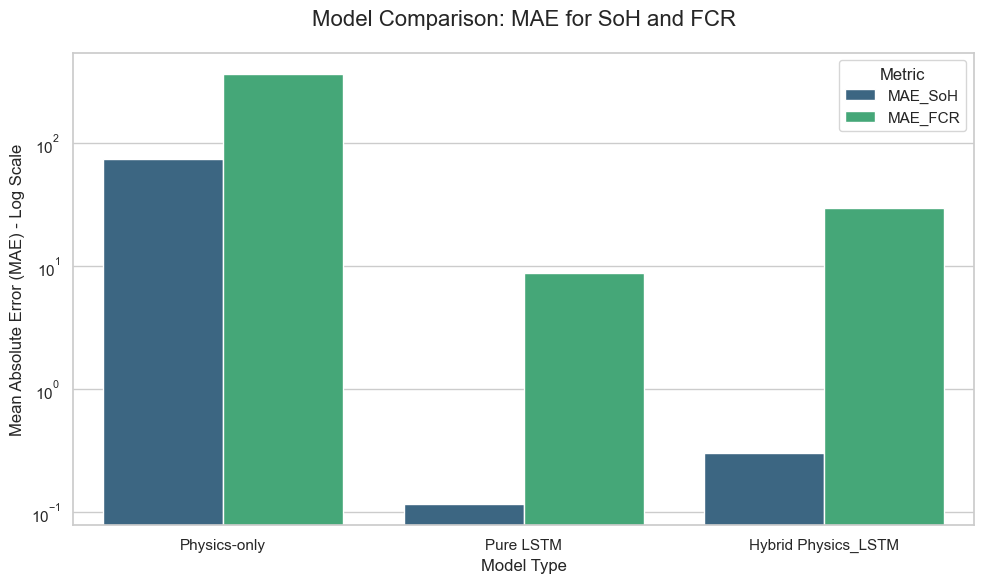

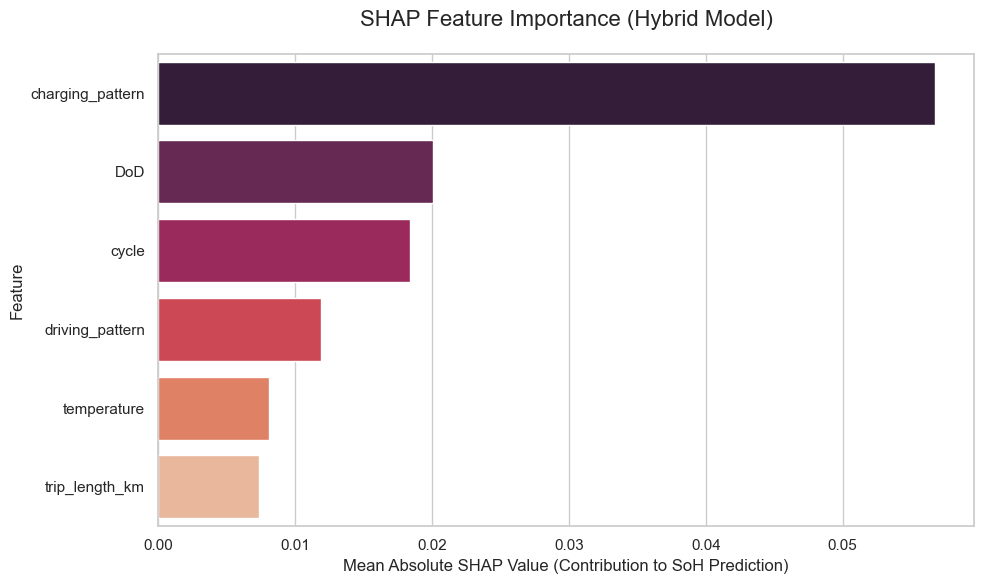

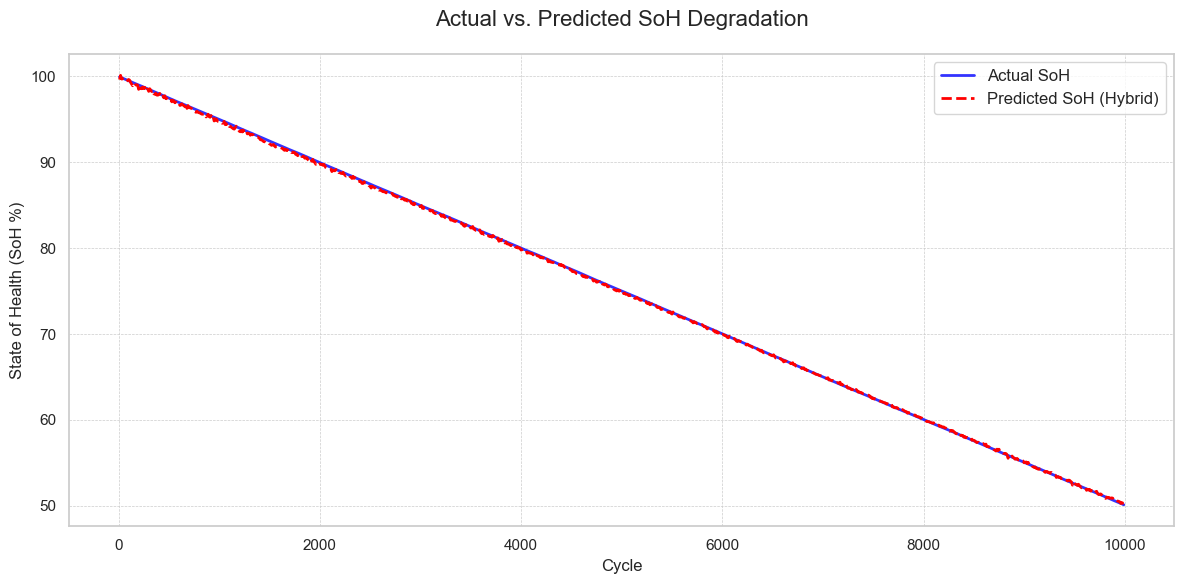

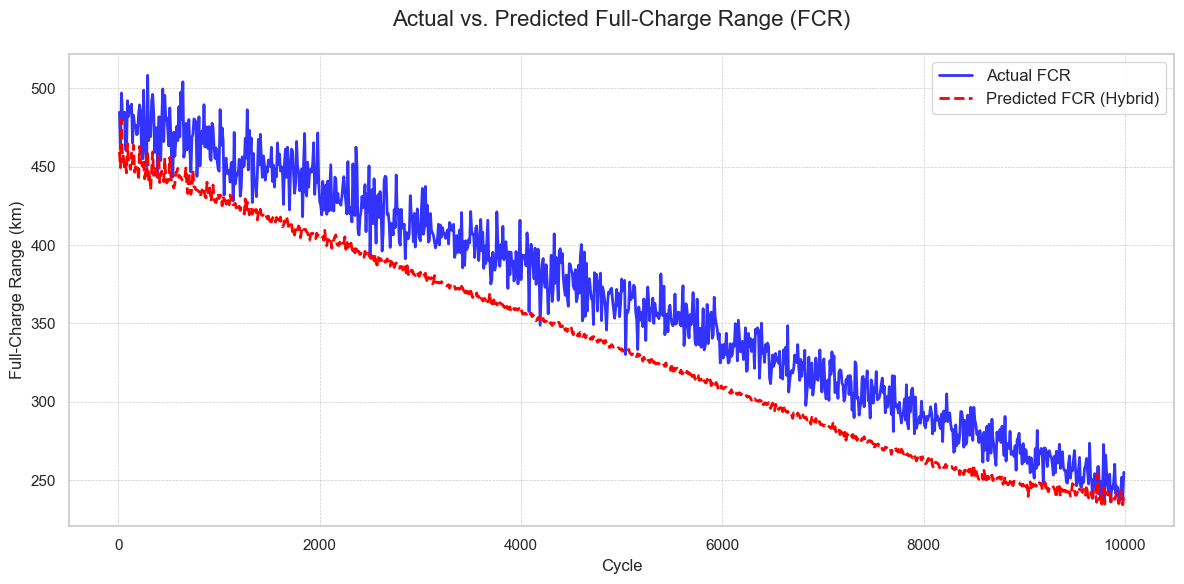

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


print("--- Starting Visualization Script ---")
warnings.filterwarnings("ignore", category=UserWarning)
sns.set(style="whitegrid")


try:
    plot_df = pd.read_csv('plotting_data.csv')
    print("Loaded 'plotting_data.csv'")
except FileNotFoundError:
    print("Error: 'plotting_data.csv' not found.")
    print("Please run the main script first to generate this file.")
    exit()


comparison_data = {
    'Model': ['Physics-only', 'Pure LSTM', 'Hybrid Physics_LSTM'],
    'MAE_SoH': [74.906337, 0.115969, 0.299139],
    'MAE_FCR': [364.348375, 8.777489, 29.431867]
}
metrics_df_comparison = pd.DataFrame(comparison_data)


shap_data = {
    'Feature': ['charging_pattern', 'DoD', 'cycle', 'driving_pattern', 'temperature', 'trip_length_km'],
    'Importance (mean abs SHAP)': [0.056754, 0.020039, 0.018427, 0.011897, 0.008068, 0.007383]
}
shap_df = pd.DataFrame(shap_data)



print("Generating Plot 1: Model Comparison...")
metrics_melted = metrics_df_comparison.melt('Model', var_name='Metric', value_name='MAE')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=metrics_melted, x='Model', y='MAE', hue='Metric', palette='viridis')
plt.title('Model Comparison: MAE for SoH and FCR', fontsize=16, pad=20)
plt.ylabel('Mean Absolute Error (MAE) - Log Scale')
plt.xlabel('Model Type')
plt.yscale('log')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('1_model_comparison_barplot.png', dpi=300)



print("Generating Plot 2: Feature Importance...")
plt.figure(figsize=(10, 6))
sns.barplot(data=shap_df, x='Importance (mean abs SHAP)', y='Feature', palette='rocket')
plt.title('SHAP Feature Importance (Hybrid Model)', fontsize=16, pad=20)
plt.xlabel('Mean Absolute SHAP Value (Contribution to SoH Prediction)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('2_shap_feature_importance.png', dpi=300)


print("Generating Plot 3: SoH Degradation...")
plot_df_sampled = plot_df.iloc[::10, :] 

plt.figure(figsize=(12, 6))
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['SoH_true'], label='Actual SoH', color='blue', alpha=0.8, linewidth=2)
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['SoH_pred'], label='Predicted SoH (Hybrid)', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted SoH Degradation', fontsize=16, pad=20)
plt.xlabel('Cycle')
plt.ylabel('State of Health (SoH %)')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('3_soh_degradation_plot.png', dpi=300)


print("Generating Plot 4: FCR Prediction...")
plt.figure(figsize=(12, 6))
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['FCR_true'], label='Actual FCR', color='blue', alpha=0.8, linewidth=2)
plt.plot(plot_df_sampled['cycle'], plot_df_sampled['FCR_pred'], label='Predicted FCR (Hybrid)', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs. Predicted Full-Charge Range (FCR)', fontsize=16, pad=20)
plt.xlabel('Cycle')
plt.ylabel('Full-Charge Range (km)')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('4_fcr_prediction_plot.png', dpi=300)

print("All Visualizations Generated Successfully")